# Training analysis for DeepRacer

This notebook has been built based on the `DeepRacer Log Analysis.ipynb` provided by the AWS DeepRacer Team. It has been reorganised and expanded to provide new views on the training data without the helper code which was moved into utility `.py` files.

## Usage

I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed after initial reading. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the logs may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io) for all the feedback about the notebooks. If you'd like, follow [my blog](https://codelikeamother.uk) where I tend to write about my experiences with AWS DeepRacer.

# Log Analysis

Let's get to it.

## Permissions

Depending on where you are downloading the data from, you will need some permissions:
* Access to CloudWatch log streams
* Access to S3 bucket to reach the log files

## Installs and setups

If you are using an AWS SageMaker Notebook to run the log analysis, you will need to ensure you install required dependencies. To do that uncomment and run the following:

In [1]:
import sys

!{sys.executable} -m pip install deepracer-utils

## Imports

Run the imports block below:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from deepracer.tracks import TrackIO, Track
from deepracer.tracks.track_utils import track_breakdown
from deepracer.logs import CloudWatchLogs as cw, \
    SimulationLogsIO as slio, \
    NewRewardUtils as nr, \
    AnalysisUtils as au, \
    PlottingUtils as pu, \
    ActionBreakdownUtils as abu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [3]:
!ls tracks/

tu = TrackIO()

AWS_track.npy			New_York_Eval_Track.npy
AmericasGeneratedInclStart.npy	New_York_Track.npy
Bowtie_track.npy		Oval_track.npy
Canada_Eval.npy			Spain_track.npy
Canada_Training.npy		Straight_track.npy
China_eval_track.npy		Tokyo_Training_track.npy
China_track.npy			Vegas_track.npy
FS_June2020.npy			Virtual_May19_Train_track.npy
H_track.npy			reInvent2019_track.npy
LGSWide.npy			reInvent2019_wide.npy
London_Loop_Train.npy		reInvent2019_wide_mirrored.npy
Mexico_track.npy		reinvent_base.npy
Mexico_track_eval.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 71 waypoints


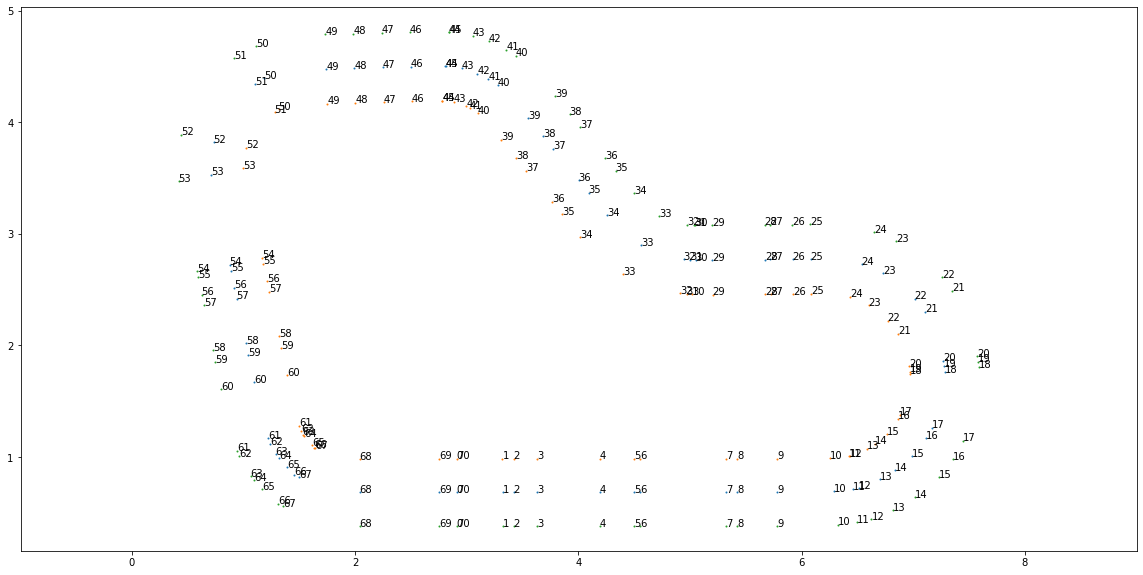

In [4]:
track: Track = tu.load_track("reinvent_base")

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [5]:
# AWS DeepRacer Console
stream_name = 'sim-j5xqxn10bbn0' ## CHANGE This to your simulation application ID
stream_name = 'sim-FTL-Branch2-v2'
#stream_name = 'sim-FTL-Branch1-v3'
#stream_name = 'sim-x8ytpg0h5t6d'
stream_name = 'sim-FTL-Branch3-v3-'
stream_name = 'sim-FTL-Branch5-v6'
fname = 'logs/deepracer-%s.log' %stream_name  # The log will be downloaded into the specified path
cw.download_log(fname, stream_prefix=stream_name)  # add force=True if you downloaded the file before but want to repeat


# DeepRacer for Dummies / ARCC repository - comment the above and uncomment
# the lines below. They rely on a magic command to list log files
# ordered by time and pick up the most recent one (index zero).
# If you want an earlier file, change 0 to larger value.
# !ls -t /workspace/venv/logs/*.log
# fname = !ls -t /workspace/venv/logs/*.log
# fname = fname[0]


# Chris Rhodes' repository
# Use a preferred way of saving the logs to a file , then set an fname value to load it
# fname = /path/to/your/log/file

Log file exists, use force=True to download again


## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the lap complete
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [6]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

In [7]:
#Uncomment the line of code below to evaluate a different reward function
#new_reward_function = 'log-analysis.rewards.reward_sample'
new_reward_function = 'log-analysis.rewards.reward_power_14june'
new_reward_function = 'log-analysis.rewards.reward_legacy_complex'
new_reward_function = 'log-analysis.rewards.reward_legacy_complex_v3'
nr.new_reward(df, track.center_line, new_reward_function) #, verbose=True)

## New reward

Note the last line above: it takes a reward class from log-analysis/rewards, imports it, instantiates and recalculates reward values based on the data from the log. This lets you do some testing before you start training and rule out some obvious things.

*If you find this confusing, don't worry, because it is confusing. You can safely ignore it for now and come back to it later.*

This operation is possible because the logs contain all information needed to recreate the params for a given step. That said some could be implemented better and some were ignored for now and should be implemented.

The sample reward mentioned in that line is located in `log-analysis/rewards/reward_sample.py` and looks like this:

```
from time import time


class Reward:
    def __init__(self, verbose=False):
        self.previous_steps = None
        self.initial_time = None
        self.verbose = verbose

    @staticmethod
    def get_time(params):
        # remember: this will not return time before
        # the first step has completed so the total
        # time for lap will be lower by about 0.2s
        return params.get('timestamp', None) or time()

    def reward_function(self, params):
        if self.previous_steps is None \
                or self.previous_steps > params['steps']:
            # new lap!
            self.initial_time = self.get_time(params)
        else:
            # we're continuing a lap
            pass

        steering_factor = 1.0

        if abs(params['steering_angle']) > 14:
            steering_factor = 0.7

        reward = float(steering_factor)

        self.previous_steps = params['steps']

        if self.verbose:
            print(params)

        return reward


reward_object = Reward()


def reward_function(params):
    return reward_object.reward_function(params)

```

After some imports a class is declared, it's called `Reward`, then the class is instantiated and a function `reward_function` is declared. This somewhat bloated structure has a couple benefits:
* It works in console/local training for actual training
* It lets you reload the definition for class Reward and retry the reward function multiple times after changes without much effort
* If you want to rely on state carried over between the steps, it's all contained in a reward object 

The reward class hides two or three tricks for you:
* `get_time` lets you abstract from machine time in log analysis - the supporting code adds one extra param, `timestamp`. That lets you get the right time value in new_reward function
* the first condition allows detecting the beginning of an episode or even start of training you can use it for some extra operations between the episodes
* `verbose` can be used to provide some noisier prints in the reward function - you can switch them on when loading the reward function above.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

If you just wrap your reward function like in the above example, you can use it in both log analysis notebook and the training.

Final warning: there is a loss of precision in the logs (rounded numbers) and also potentially potential bugs. If you find any, please fix, please report.

## Graphs

The original notebook has provided some great ideas on what could be visualised in the graphs. Below examples are a slightly extended version. Let's have a look at what they are presenting and what this may mean to your training.

### Training progress

As you have possibly noticed by now, training episodes are grouped into iterations and this notebook also reflects it. What also marks it are checkpoints in the training. After each iteration a set of ckpt files is generated - they contain outcomes of the training, then a model.pb file is built based on that and the car begins a new iteration. Looking at the data grouped by iterations may lead you to a conclusion, that some earlier checkpoint would be a better start for a new training. While this is limited in the AWS DeepRacer Console, with enough disk space you can keep all the checkpoints along the way and use one of them as a start for new training (or even as a submission to a race).

While the episodes in a given iteration are a mixture of decision process and random guesses, mean results per iteration may show a specific trend. Mean values are accompanied by standard deviation to show the concentration of values around the mean.

#### Rewards per Iteration

You can see these values as lines or dots per episode in the AWS DeepRacer console. When the reward goes up, this suggests that a car is learning and improving with regards to a given reward function. **This does not have to be a good thing.** If your reward function rewards something that harms performance, your car will learn to drive in a way that will make results worse.

At first the rewards just grow if the progress achieved grows. Interesting things may happen slightly later in the training:

* The reward may go flat at some level - it might mean that the car can't get any better. If you think you could still squeeze something better out of it, review the car's progress and consider updating the reward function, the action space, maybe hyperparameters, or perhaps starting over (either from scratch or from some previous checkpoint)
* The reward may become wobbly - here you will see it as a mesh of dots zig-zagging. It can be a gradually growing zig-zag or a roughly stagnated one. This usually means the learning rate hyperparameter is too high and the car started doing actions that oscilate around some local extreme. You can lower the learning rate and hope to step closer to the extreme. Or run away from it if you don't like it
* The reward plunges to near zero and stays roughly flat - I only had that when I messed up the hyperparameters or the reward function. Review recent changes and start training over or consider starting from scratch

The Standard deviation says how close from each other the reward values per episode in a given iteration are. If your model becomes reasonably stable and worst performances become better, at some point the standard deviation may flat out or even decrease. That said, higher speeds usually mean there will be areas on track with higher risk of failure. This may bring the value of standard deviation to a higher value and regardless of whether you like it or not, you need to accept it as a part of fighting for significantly better times.

#### Time per iteration

I'm not sure how useful this graph is. I would worry if it looked very similar to the reward graph - this could suggest that slower laps will be getting higher rewards. But there is a better graph for spotting that below.

#### Progress per Iteration

This graph usually starts low and grows and at some point it will get flatter. The maximum value for progress is 100% so it cannot grow without limits. It usually shows similar initial behaviours to reward and time graphs. I usually look at it when I alter an action in training. In such cases this graph usually dips a bit and then returns or goes higher.

#### Total reward per episode

This graph has been taken from the orignal notebook and can show progress on certain groups of behaviours. It usually forms something like a triangle, sometimes you can see a clear line of progress that shows some new way has been first taught and then perfected.

#### Mean completed lap times per iteration

Once we have a model that completes laps reasonably often, we might want to know how fast the car gets around the track. This graph will show you that. I use it quite often when looking for a model to shave a couple more miliseconds. That said it has to go in pair with the last one:

#### Completion rate per iteration

It represents how big part of all episodes in an iteration is full laps. The value is from range [0, 1] and is a result of deviding amount of full laps in iteration by amount of all episodes in iteration. I say it has to go in pair with the previous one because you not only need a fast lapper, you also want a race completer.

The higher the value, the more stable the model is on a given track.

In [8]:
simulation_agg = au.simulation_agg(df)

# View ten best rewarded episodes in the training
#simulation_agg.nlargest(500, 'new_reward')
simulation_agg.nlargest(500, 'progress')
#simulation_agg.nsmallest(500, 'time_if_complete')
#simulation_agg.nlargest(500, 'progress')
simulation_agg.nlargest(500, 'reward')[['iteration', 'progress', 'reward', 'steps']]

,iteration,progress,reward,steps
358,18,100.0000,601.3856,184
286,15,100.0000,577.7521,177
298,15,93.1112,554.5469,188
293,15,85.4490,514.2625,156
177,9,86.6338,489.3567,158
...,...,...,...,...
275,14,5.6256,36.4863,14
364,19,4.6310,36.2734,14
375,19,5.0464,36.0696,15
305,16,3.8055,36.0077,14


In [9]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 20)

# View all steps data for episode 111
df[df['episode']==196]
#df[df['episode']==29] # Check highest score

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
9035,10,196,1,0.8918,2.6429,-78.2911,30.0,1.0,18.0,1.5300,0,True,0.7924,55,17.67,1592846894.9511905,3.06000
9036,10,196,2,0.8931,2.6384,-78.1430,0.0,1.0,9.0,2.0000,0,True,0.8188,55,17.67,1592846895.019119,4.00000
9037,10,196,3,0.8983,2.6209,-77.5713,-20.0,2.0,4.0,2.0400,0,True,0.9220,55,17.67,1592846895.0856216,6.12000
9038,10,196,4,0.9071,2.5881,-77.0148,0.0,1.0,9.0,2.0000,0,True,1.1136,56,17.67,1592846895.1536639,4.00000
9039,10,196,5,0.9203,2.5388,-76.4070,-20.0,2.0,4.0,2.0400,0,True,1.4023,56,17.67,1592846895.2184315,6.12000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9084,10,196,50,4.2004,0.4981,-33.3844,-10.0,2.0,7.0,3.4000,0,True,27.3016,4,17.67,1592846898.4347723,12.24000
9085,10,196,51,4.2711,0.4436,-35.4463,-20.0,2.0,4.0,3.0600,0,False,27.7014,4,17.67,1592846898.5005276,12.24000
9086,10,196,52,4.3432,0.3788,-38.8477,-30.0,3.0,2.0,3.0600,0,False,28.1094,4,17.67,1592846898.5654297,12.24000
9087,10,196,53,4.4143,0.2999,-44.0165,-30.0,2.0,1.0,3.0600,0,False,28.5119,5,17.67,1592846898.6342866,12.24000


In [27]:
simulation_agg = au.simulation_agg(df)

simulation_agg['new_reward_per_step'] = simulation_agg['new_reward'] / simulation_agg['steps']
simulation_agg['reward_per_step'] = simulation_agg['reward'] / simulation_agg['steps']

pd.set_option('display.max_rows', 100)


# View ten best rewarded episodes in the training
simulation_agg.nsmallest(500, 'time_if_complete')
simulation_agg.nlargest(500, 'progress')
#simulation_agg.nlargest(50, 'new_reward_per_step')
simulation_agg[simulation_agg['progress'] > 99].nsmallest(500, 'time_if_complete')
#simulation_agg[simulation_agg['progress'] > 99].nlargest(50, 'new_reward_per_step')
#simulation_agg[simulation_agg['progress'] > 80].nlargest(50, 'reward_per_step')
#simulation_agg.nlargest(50, 'reward')
#simulation_agg.nlargest(40, 'new_reward')

,iteration,episode,steps,start_at,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile,new_reward_per_step,reward_per_step
286,15,286,177,21,100.0,11.969981,1233.34,1.638418,577.7521,11.969981,577.7521,3rd,6.968023,3.264136
358,18,358,184,64,100.0,12.237685,1200.30,1.603261,601.3856,12.237685,601.3856,4th,6.523370,3.268400


In [11]:
pd.set_option('display.max_rows', 200)

episode_id = 490

episode_df = df[(df['episode'] == episode_id)]

print("{}/{}".format(len(episode_df[(df['reward'] < df['reward'].median())]), len(episode_df)))
episode_df[(df['reward'] < df['reward'].median())]
episode_df


44/86


,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
23304,25,490,1,4.0728,3.3949,129.1632,30.0,3.0,20.0,3.0600,0,True,0.7926,35,17.67,1592848995.321355,6.12000
23305,25,490,2,4.0706,3.3970,129.3476,20.0,1.0,15.0,1.5300,0,True,0.8097,35,17.67,1592848995.3871222,3.06000
23306,25,490,3,4.0535,3.4094,131.0128,-30.0,3.0,2.0,2.0400,0,True,0.9250,35,17.67,1592848995.4562268,6.12000
23307,25,490,4,4.0248,3.4312,133.6475,-20.0,1.0,3.0,1.5300,0,True,1.1232,36,17.67,1592848995.5255694,3.06000
23308,25,490,5,3.9846,3.4613,136.4380,-30.0,1.0,0.0,1.5300,0,True,1.3990,36,17.67,1592848995.589696,6.12000
23309,25,490,6,3.9409,3.4950,138.3763,-10.0,3.0,8.0,2.2667,0,True,1.7032,36,17.67,1592848995.6586413,12.24000
23310,25,490,7,3.8779,3.5445,139.8736,20.0,1.0,15.0,1.5300,0,True,2.1456,36,17.67,1592848995.7248256,6.12000
23311,25,490,8,3.8183,3.5887,141.1778,-20.0,1.0,3.0,1.5300,0,True,2.5524,37,17.67,1592848995.7888918,6.12000
23312,25,490,9,3.7589,3.6311,142.5063,-20.0,2.0,4.0,2.0400,0,True,2.9510,37,17.67,1592848995.858712,12.24000
23313,25,490,10,3.6995,3.6750,142.9127,0.0,1.0,9.0,2.0000,0,True,3.3558,37,17.67,1592848995.9226623,8.00000


In [12]:
pd.set_option('display.max_rows', 100)

episode_id = 314

episode_df = df[(df['episode'] == episode_id)]

print("{}/{}".format(len(episode_df[(df['reward'] < df['reward'].median())]), len(episode_df)))
episode_df[(df['reward'] < df['reward'].median())]
df[df['reward'] < 1e-3].nsmallest(100, 'episode')


27/51


,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward


Reward less than average


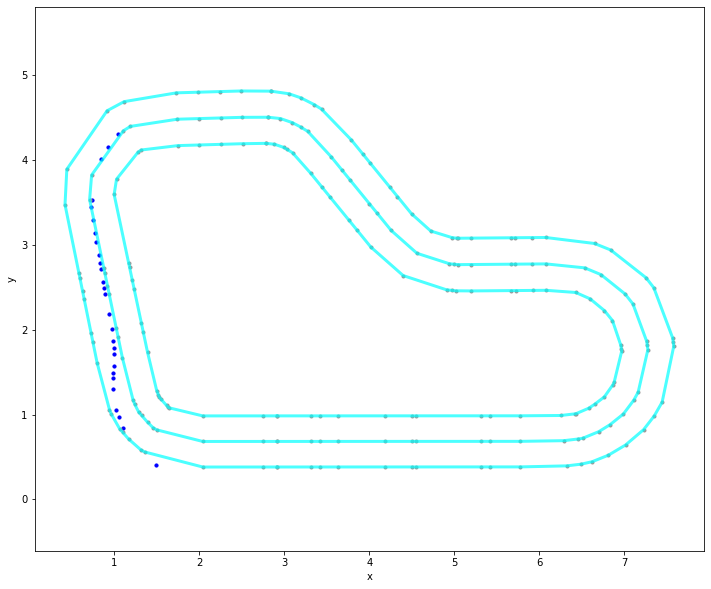

Points were speed was less than average


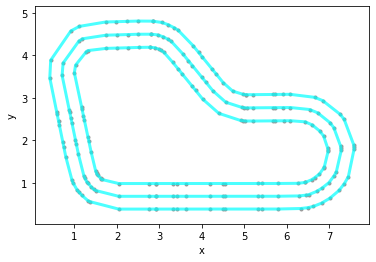

Points were speed was less than average but reward is above percentile 50


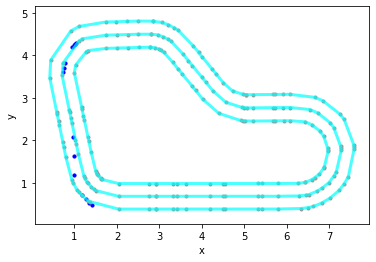

Points were speed is higher than median but reward is below percentile 75%


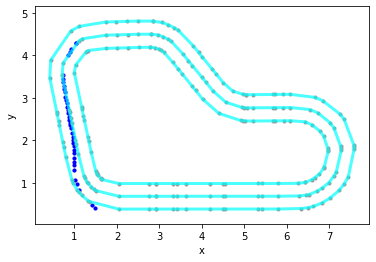

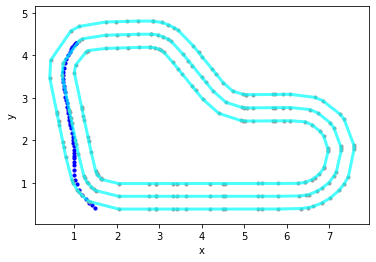

<Figure size 432x288 with 0 Axes>

In [13]:
episode_id = 314



print("Reward less than average")
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df[df['reward'] < df['reward'].median()], track)
#pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df[df['reward'] < 4.0], track)

print("Points were speed was less than average")
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df[df['throttle'] < df['throttle'].median()], track)

print("Points were speed was less than average but reward is above percentile 50")
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df[(df['throttle'] <= df['throttle'].median()) & (df['reward'] > df['reward'].quantile(0.50))], track)

print("Points were speed is higher than median but reward is below percentile 75%")
pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df[(df['throttle'] >= df['throttle'].median()) & (df['reward'] < df['reward'].quantile(0.75))], track)


pu.plot_selected_laps(simulation_agg[simulation_agg['episode'] == episode_id], df, track)

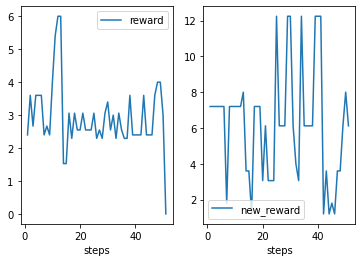

In [14]:
lap_data = df[df['episode'] == episode_id][:]

fig, axs = plt.subplots(1,2)
                          
#au.scatter_aggregates(lap_data, 'Stats for complete laps')
lap_data.plot(ax=axs[0], x='steps', y='reward')
lap_data.plot(ax=axs[1], x='steps', y='new_reward')

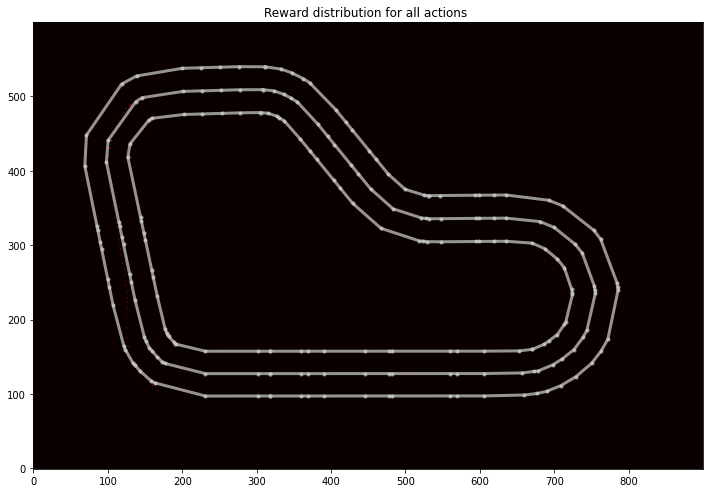

<Figure size 432x288 with 0 Axes>

In [15]:
#If you'd like some other colour criterion, you can add
#a value_field parameter and specify a different column

#pu.plot_track(df, track)
#pu.plot_track(df[df['iteration'] == iteration_id], track)
episode_id = 314
pu.plot_track(df[df['episode'] == episode_id], track)

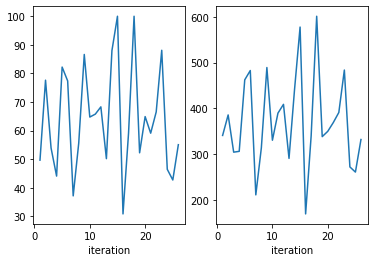

In [16]:
# Best scores for each iteration

fig, axs = plt.subplots(1,2)
                          
au.simulation_agg(df).groupby(['iteration'])['progress'].max().plot(ax=axs[0], x='iteration', y='progress')
au.simulation_agg(df).groupby(['iteration'])['reward'].max().plot(ax=axs[1], x='iteration', y='reward')



,steps,reward,new_reward,progress,progress_per_step,throttle
count,6142.000000,6142.000000,6142.000000,6142.000000,6142.000000,6142.000000
mean,33.197818,3.045142,6.043294,16.011849,0.440159,1.662162
std,27.731852,1.259471,3.446253,15.038922,0.103339,0.788286
min,1.000000,0.001500,0.001200,0.763000,0.223700,1.000000
25%,12.000000,2.295000,3.600000,4.414725,0.373679,1.000000
50%,26.000000,2.666700,6.120000,11.908100,0.445408,1.000000
75%,46.000000,3.600000,7.200000,22.702575,0.502847,2.000000
max,153.000000,6.000000,16.000000,88.095800,0.814300,3.000000


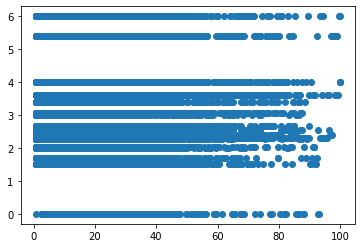

In [17]:
plt.scatter(df['progress'], df['reward'])
df['progress_per_step'] = df['progress'] / df['steps']

df[['steps', 'reward', 'new_reward', 'progress', 'progress_per_step', 'throttle']].describe()

quantile_size = len(df)//4
df[:quantile_size][['steps', 'reward', 'new_reward', 'progress', 'progress_per_step', 'throttle']].describe()

df[quantile_size:quantile_size*2][['steps', 'reward', 'new_reward', 'progress', 'progress_per_step', 'throttle']].describe()
#df[quantile_size*2:quantile_size*3][['steps', 'reward', 'new_reward', 'progress', 'progress_per_step', 'throttle']].describe()
df[quantile_size*3:][['steps', 'reward', 'new_reward', 'progress', 'progress_per_step', 'throttle']].describe()

,steps,reward,new_reward,progress
count,24565.000000,24565.000000,24565.000000,24565.000000
mean,34.150295,3.029915,6.029217,16.617584
std,29.744067,1.258962,3.406214,16.229487
min,1.000000,0.001500,0.001200,0.680900
25%,12.000000,2.295000,3.600000,4.365900
50%,26.000000,2.666700,6.120000,11.942700
75%,47.000000,3.600000,7.200000,23.478000
max,188.000000,6.000000,16.000000,100.000000


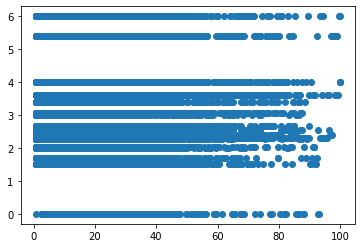

In [18]:
plt.scatter(df['progress'], df['reward'])
df[['steps', 'reward', 'new_reward', 'progress']].describe()

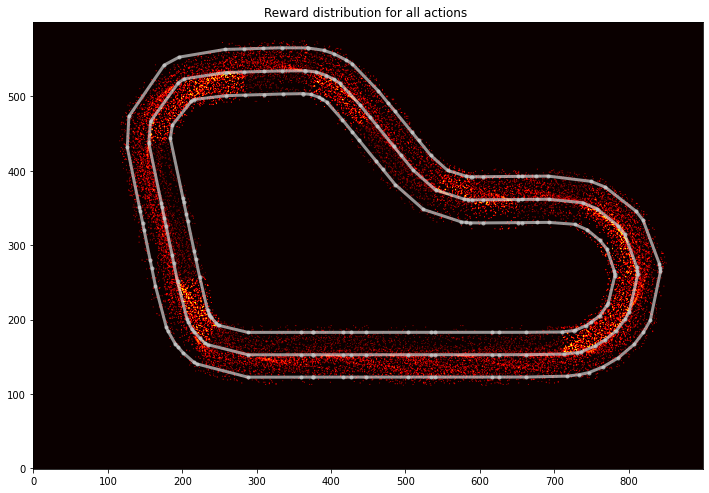

<Figure size 432x288 with 0 Axes>

In [19]:
pu.plot_track(df, track, value_field='reward')

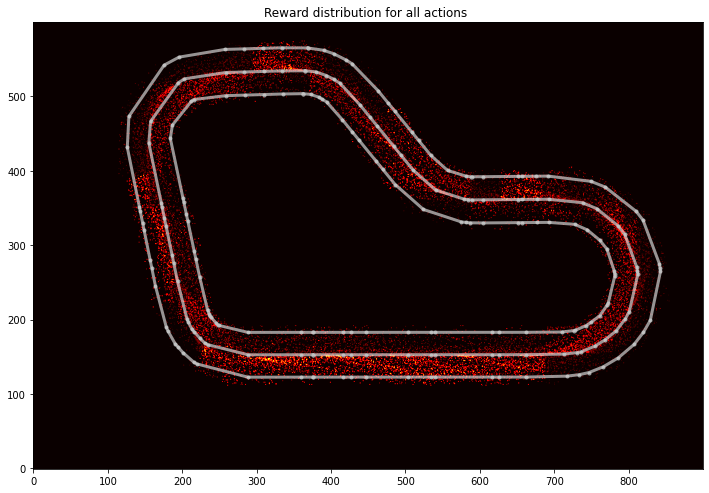

<Figure size 432x288 with 0 Axes>

In [20]:
pu.plot_track(df, track, value_field='new_reward')

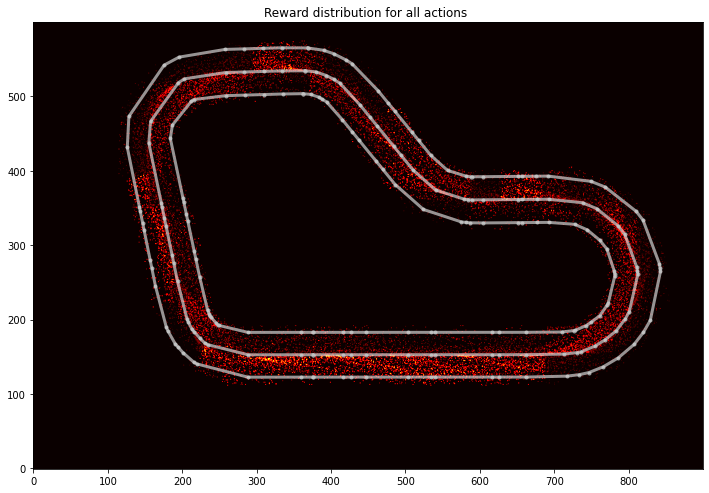

<Figure size 432x288 with 0 Axes>

In [21]:
pu.plot_track(df, track, value_field='new_reward')

In [22]:
episodes_to_plot = df.nlargest(3,'progress')


# highest progress from all episodes:
#simulation_agg = au.simulation_agg(df)
episodes_to_plot = simulation_agg.nlargest(3,'progress')
print(episodes_to_plot)
#episodes_to_plot = df


#pu.plot_selected_laps(episodes_to_plot, df, track)


     iteration  episode  steps  start_at  progress       time  new_reward  \
286         15      286    177        21  100.0000  11.969981  1233.34000   
358         18      358    184        64  100.0000  12.237685  1200.30000   
298         15      298    188        64   93.1112  12.505724  1159.70824   

     throttle    reward  time_if_complete  reward_if_complete quintile  \
286  1.638418  577.7521         11.969981          577.752100      3rd   
358  1.603261  601.3856         12.237685          601.385600      4th   
298  1.638298  554.5469         13.430956          595.574861      3rd   

     new_reward_per_step  reward_per_step  
286             6.968023         3.264136  
358             6.523370         3.268400  
298             6.168661         2.949718  


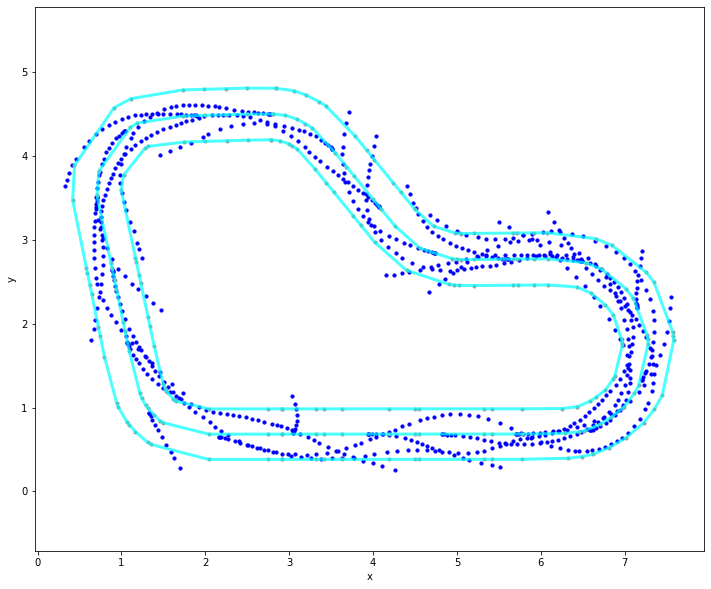

<Figure size 432x288 with 0 Axes>

In [23]:
iteration_id = df['iteration'].min()

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

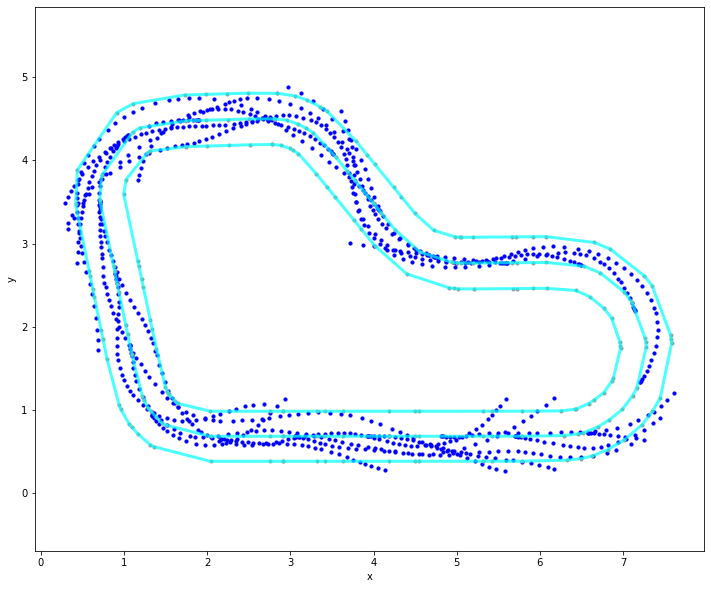

<Figure size 432x288 with 0 Axes>

In [24]:
iteration_id = df['iteration'].median()

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

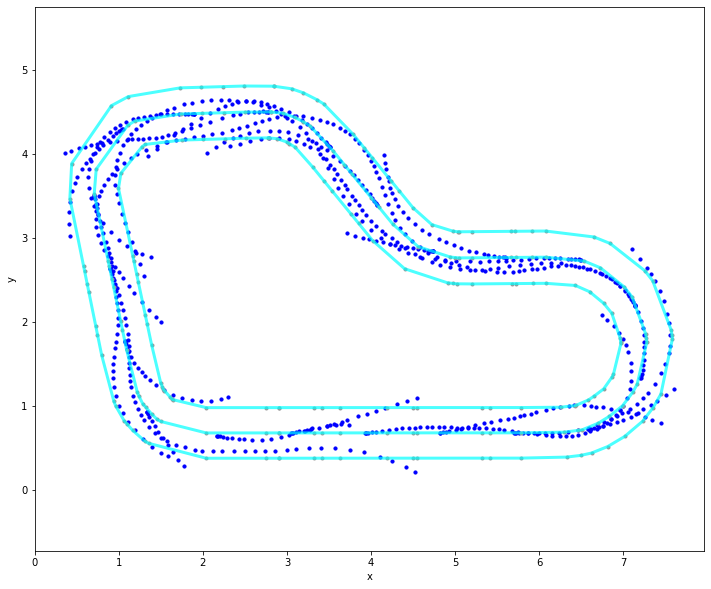

<Figure size 432x288 with 0 Axes>

In [25]:
iteration_id = df['iteration'].max()

pu.plot_selected_laps([iteration_id], df, track, section_to_plot = 'iteration')

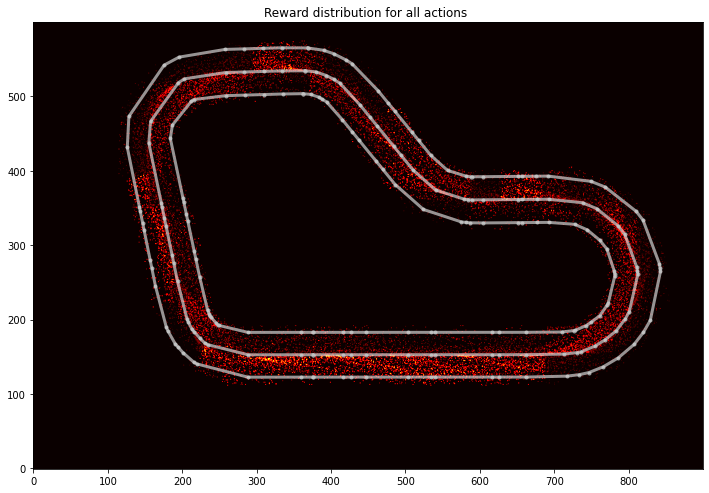

<Figure size 432x288 with 0 Axes>

In [26]:
#Uncomment the line of code below to evaluate a different reward function
#new_reward_function = 'log-analysis.rewards.reward_sample'
new_reward_function = 'log-analysis.rewards.reward_power_14june'
new_reward_function = 'log-analysis.rewards.reward_legacy_complex'
new_reward_function = 'log-analysis.rewards.reward_legacy_complex_v3'
df_small = df#[:5000]
nr.new_reward(df_small, track.center_line, new_reward_function) #, verbose=True)

pu.plot_track(df_small, track, value_field='new_reward')